In [1]:
import gymnasium as gym
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from collections import namedtuple
from collections import deque
import random 
from itertools import count
from IPython import display

#env=gym.make('CartPole-v1', render_mode='human')
env=gym.make('CartPole-v1')
plt.ion()
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

  def __init__(self, capacity):
    self.memory = deque([], maxlen=capacity)

  def push(self, *args):
    self.memory.append(Transition(*args))

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

In [3]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1=nn.Linear(n_observations, 128)
        self.layer2=nn.Linear(128, 128)
        self.layer3=nn.Linear(128, n_actions)

    def forward(self, x):
        x=F.relu(self.layer1(x))
        x=F.relu(self.layer2(x))
        return self.layer3(x)

In [4]:
batch_size=128
gamma=0.99
eps_start=0.9
eps_end=0.05
eps_decay=1000
tau=0.005
lr=1e-4

n_actions=env.action_space.n
state, info=env.reset()
n_observations=len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
print(device)
optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = eps_end + (eps_start - eps_end) * math.exp(-1. * steps_done / eps_decay)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_rewards=[]

def plot_rewards(show_result=False):
    plt.figure(1)
    #rewards_t=torch.tensor(episode_rewards, dtype=torch.float)
    if(show_result):
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...') 
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.plot(episode_rewards)

    plt.pause(0.001)
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())

cuda


In [5]:
def optimize_model():
  if len(memory) < batch_size:
    return
  transitions=memory.sample(batch_size)

  batch=Transition(*zip(*transitions))

  non_final_mask=torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)

  non_final_next_states=torch.cat([s for s in batch.next_state if s is not None])

  state_batch=torch.cat(batch.state)
  action_batch=torch.cat(batch.action)
  reward_batch=torch.cat(batch.reward)

  state_action_values=policy_net(state_batch).gather(1, action_batch)

  next_state_values=torch.zeros(batch_size, device=device)
  with torch.no_grad():
    next_state_values[non_final_mask]=target_net(non_final_next_states).max(1).values
  expected_state_action_values=(next_state_values*gamma)+reward_batch

  criterion=nn.SmoothL1Loss()
  loss=criterion(state_action_values, expected_state_action_values.unsqueeze(1))

  optimizer.zero_grad()
  loss.backward()

  torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
  optimizer.step()

Complete


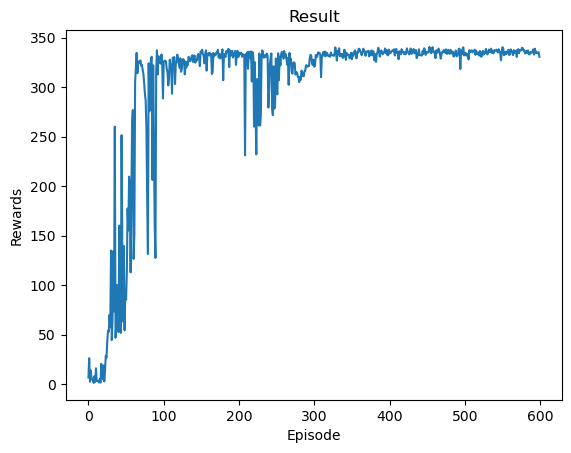

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [6]:
if torch.cuda.is_available():
  num_episodes=600
else:
  num_episodes=50

for i_episode in range(num_episodes):
  r=0
  state, info=env.reset()
  state=torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
  for t in count():
    action=select_action(state)
    observation, reward, terminated, truncated, _=env.step(action.item())
    x, x_dot, theta, theta_dot=observation
    r1=(env.x_threshold-abs(x))/env.x_threshold - 0.8
    r2=(env.theta_threshold_radians-abs(theta))/env.theta_threshold_radians-0.5
    #r=r+reward
    r=r+r1+r2
    #print(r)
    #reward_t=torch.tensor([reward], device=device)
    reward_t=torch.tensor([r1+r2], device=device)
    done=terminated or truncated

    if terminated:
      next_state=None
    else:
      next_state=torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    memory.push(state, action, next_state, reward_t)

    state=next_state

    optimize_model()

    target_net_state_dict=target_net.state_dict()
    policy_net_state_dict=policy_net.state_dict()
    for key in policy_net_state_dict:
      target_net_state_dict[key]=policy_net_state_dict[key]*tau+target_net_state_dict[key]*(1-tau)
    target_net.load_state_dict(target_net_state_dict)
    if(done):
      
      #print(r)
      break
  #print(r)
  episode_rewards.append(r)
  
  plot_rewards()
  env.render()

print('Complete')
plot_rewards(show_result=True)
plt.ioff()
plt.show()
      
    